In [1]:
ls

Cohort_Analysis_Full.ipynb  Online Retail.xlsx  OnlineSampled.xlsx


In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import datetime as dt

# Load Online Retail dataset
The original dataset can be found here - http://archive.ics.uci.edu/ml/datasets/online+retail

It does have some outliers and missing data, and requires some cleaning. I have created a separate git repo for that, and saves the cleaned file as `OnlineClean.xlsx` - you can find the notebook, as well as original and cleaned datasets in the repo - https://github.com/karolisurbonas/cleaning-online-retail-dataset

I have also created a smaller version of the file with only `United Kingdom` filtered from the `Country` values, and randomly sampled 20% of the data for faster processing - the file is called `OnlineSampled.xlsx`.

In [3]:
# Pre-processed file
#online = pd.read_excel('OnlineClean.xlsx')

# Further cleaned file: UK-only, randomly sampled 20% of the data
online = pd.read_excel('OnlineSampled.xlsx')

In [4]:
online.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
416792,572558,22745,POPPY'S PLAYHOUSE BEDROOM,6,2011-10-25 08:26:00,2.10,14286,United Kingdom
482904,577485,23196,VINTAGE LEAF MAGNETIC NOTEPAD,1,2011-11-20 11:56:00,1.45,16360,United Kingdom
263743,560034,23299,FOOD COVER WITH BEADS SET 2,6,2011-07-14 13:35:00,3.75,13933,United Kingdom
495549,578307,72349B,SET/6 PURPLE BUTTERFLY T-LIGHTS,1,2011-11-23 15:53:00,2.10,17290,United Kingdom
204384,554656,21756,BATH BUILDING BLOCK WORD,3,2011-05-25 13:36:00,5.95,17663,United Kingdom


# 01. Building time-based cohorts

In this section we are going to build time-based cohorts that will assign the acquisition month to each customer i.e. the month when each customer made their first paid transaction with this company.

We will then calculate several metrics such:
 - retention
 - average quantity
 - average price
 - average total basket sum

In [5]:
online['TotalSum'] = online['Quantity'] * online['UnitPrice']

In [6]:
online.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalSum
416792,572558,22745,POPPY'S PLAYHOUSE BEDROOM,6,2011-10-25 08:26:00,2.10,14286,United Kingdom,12.60
482904,577485,23196,VINTAGE LEAF MAGNETIC NOTEPAD,1,2011-11-20 11:56:00,1.45,16360,United Kingdom,1.45
263743,560034,23299,FOOD COVER WITH BEADS SET 2,6,2011-07-14 13:35:00,3.75,13933,United Kingdom,22.50
495549,578307,72349B,SET/6 PURPLE BUTTERFLY T-LIGHTS,1,2011-11-23 15:53:00,2.10,17290,United Kingdom,2.10
204384,554656,21756,BATH BUILDING BLOCK WORD,3,2011-05-25 13:36:00,5.95,17663,United Kingdom,17.85


### Convert unique customer identifier into string

It will be easier to use for later aggregation

In [7]:
online['CustomerID'] = online['CustomerID'].astype(str)
len(set(online['CustomerID']))

3701

### Create an "InvoiceMonth" column
This column will be later used for defining the acquisition month for each customer

In [8]:
online['InvoiceMonth'] = online['InvoiceDate'].apply(lambda x: dt.datetime(x.year, x.month, 1))

### Assign acquisition month cohort per customer
We're going to use **transform** function on the dataframe to calculate the first month of each customer's purchase that will define their month of acquisition.

In [9]:
online['CohortMonth'] = online.groupby('CustomerID')['InvoiceMonth'].transform('min')

### Calculate cohort index - ***nth*** month offset
Cohort index will allow us to normalize the metrics and compare them for each monthly cohort. This way we can assess the performance of each monthly cohort for a given ***nth*** month after customer's acquisition.

What we do is take a difference between the dates, and add plus one, in order to have one based indexing which is easier to interpret in a business context.

In [10]:
online['CohortIndex'] = (
    online['InvoiceMonth'].apply(lambda x: x.year) - online['CohortMonth'].apply(lambda x: x.year))*12 + \
    (online['InvoiceMonth'].apply(lambda x: x.month) - online['CohortMonth'].apply(lambda x: x.month)) + 1

### Creating a string cohort month value
We will use this column to create a retention heatmap, and it will look much more beautiful in a short year-month format, than a full timestamp.

In [11]:
online['CohortMonth'] = online['CohortMonth'].apply(lambda x: x.strftime('%Y-%m'))

In [12]:
online.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalSum,InvoiceMonth,CohortMonth,CohortIndex
416792,572558,22745,POPPY'S PLAYHOUSE BEDROOM,6,2011-10-25 08:26:00,2.10,14286,United Kingdom,12.60,2011-10-01,2011-04,7
482904,577485,23196,VINTAGE LEAF MAGNETIC NOTEPAD,1,2011-11-20 11:56:00,1.45,16360,United Kingdom,1.45,2011-11-01,2011-09,3
263743,560034,23299,FOOD COVER WITH BEADS SET 2,6,2011-07-14 13:35:00,3.75,13933,United Kingdom,22.50,2011-07-01,2011-07,1
495549,578307,72349B,SET/6 PURPLE BUTTERFLY T-LIGHTS,1,2011-11-23 15:53:00,2.10,17290,United Kingdom,2.10,2011-11-01,2011-11,1
204384,554656,21756,BATH BUILDING BLOCK WORD,3,2011-05-25 13:36:00,5.95,17663,United Kingdom,17.85,2011-05-01,2011-02,4


### Create cohorts dataset with raw metrics
This is a fundamental step where metrics are defined. In this case we are creating three metrics: customer count, average price, and average quantity. We are going to use only the first one - customer count - to measure retention rate.

In [13]:
grouping = online.groupby(['CohortMonth', 'CohortIndex'])

cohort_data = grouping.agg({'CustomerID': pd.Series.nunique,
                           'UnitPrice': np.mean,
                           'Quantity': np.mean,
                           'TotalSum': np.mean})

cohort_data.rename(columns = {'CustomerID': 'CustomerCount',
                           'UnitPrice': 'AveragePrice',
                           'Quantity': 'AverageQuantity',
                           'TotalSum': 'AverageTotalSum'}, inplace = True)

### Create a pivot table with active purchasers from each cohort
We will create a pivot table with ***CohortMonth*** in rows, and ***CohortIndex*** in columns, with ***CustomerCount*** as the values. 

In [14]:
cohort_data.reset_index(level=['CohortMonth', 'CohortIndex'], inplace=True)
cohort_counts = cohort_data.pivot(index='CohortMonth', columns='CohortIndex', values='CustomerCount')

In [15]:
cohort_counts

CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12,13
CohortMonth,,,,,,,,,,,,,
2010-12,716.0,246.0,221.0,251.0,245.0,285.0,249.0,236.0,240.0,265.0,254.0,348.0,172.0
2011-01,332.0,69.0,82.0,81.0,110.0,90.0,82.0,86.0,104.0,102.0,124.0,45.0,NaN
2011-02,316.0,58.0,57.0,83.0,85.0,74.0,80.0,83.0,86.0,95.0,28.0,NaN,NaN
2011-03,388.0,63.0,100.0,76.0,83.0,67.0,98.0,85.0,107.0,38.0,NaN,NaN,NaN
2011-04,255.0,49.0,52.0,49.0,47.0,52.0,56.0,59.0,17.0,NaN,NaN,NaN,NaN
2011-05,249.0,40.0,43.0,36.0,52.0,58.0,61.0,22.0,NaN,NaN,NaN,NaN,NaN
2011-06,207.0,33.0,26.0,41.0,49.0,62.0,19.0,NaN,NaN,NaN,NaN,NaN,NaN
2011-07,173.0,28.0,31.0,38.0,44.0,17.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08,139.0,30.0,28.0,35.0,14.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Calculate retention rates
First, we're going to extract cohort size on the first month of their tenure with the company. Next, we will divide the number of active purchasers from each cohort by the size of that cohort. The result is a retention metric per each monthly cohort. 

In [16]:
cohort_sizes = cohort_counts[1].values
retention = cohort_counts.divide(cohort_sizes, axis=0)

In [17]:
retention

CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12,13
CohortMonth,,,,,,,,,,,,,
2010-12,1.0,0.343575,0.308659,0.350559,0.342179,0.398045,0.347765,0.329609,0.335196,0.370112,0.354749,0.486034,0.240223
2011-01,1.0,0.207831,0.246988,0.243976,0.331325,0.271084,0.246988,0.259036,0.313253,0.307229,0.373494,0.135542,NaN
2011-02,1.0,0.183544,0.180380,0.262658,0.268987,0.234177,0.253165,0.262658,0.272152,0.300633,0.088608,NaN,NaN
2011-03,1.0,0.162371,0.257732,0.195876,0.213918,0.172680,0.252577,0.219072,0.275773,0.097938,NaN,NaN,NaN
2011-04,1.0,0.192157,0.203922,0.192157,0.184314,0.203922,0.219608,0.231373,0.066667,NaN,NaN,NaN,NaN
2011-05,1.0,0.160643,0.172691,0.144578,0.208835,0.232932,0.244980,0.088353,NaN,NaN,NaN,NaN,NaN
2011-06,1.0,0.159420,0.125604,0.198068,0.236715,0.299517,0.091787,NaN,NaN,NaN,NaN,NaN,NaN
2011-07,1.0,0.161850,0.179191,0.219653,0.254335,0.098266,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08,1.0,0.215827,0.201439,0.251799,0.100719,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Plot retention heatmap
We will use **Seaborn** library which we have imported earlier to build an easy-to-read heatmap chart.

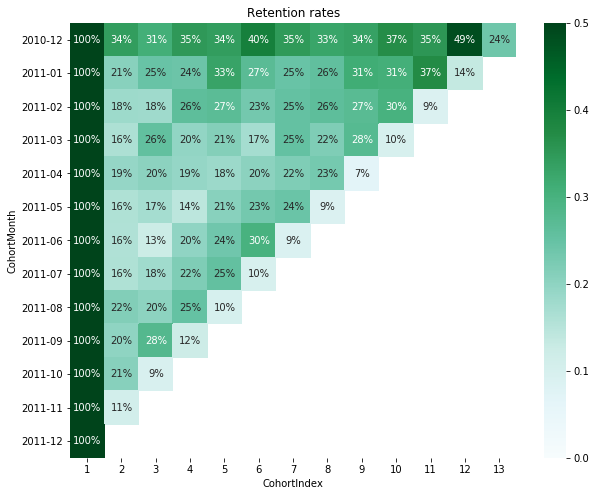

In [18]:
import seaborn as sns

plt.figure(figsize=(10, 8))
plt.title('Retention rates')
sns.heatmap(retention, annot=True, fmt='.0%', vmin=0.0, vmax=0.5, cmap='BuGn')
plt.show()

### Calculate average monthly spend per cohort and plot a heatmap

In [19]:
cohort_totalsum = cohort_data.pivot(index='CohortMonth', columns='CohortIndex', values='AverageTotalSum')
cohort_totalsum

CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12,13
CohortMonth,,,,,,,,,,,,,
2010-12,20.823904,19.902873,20.745148,19.544265,18.727043,24.401730,20.978260,21.945392,22.193310,23.284388,28.806344,18.583068,25.375448
2011-01,21.432036,18.184403,19.440934,24.598602,26.487684,23.421320,29.640207,29.025451,40.629781,20.467886,21.572219,20.141088,NaN
2011-02,18.166968,22.025903,17.157601,19.782206,27.472159,19.384457,25.880923,21.416679,21.665621,24.944229,23.530097,NaN,NaN
2011-03,17.477006,19.246418,23.221840,16.106628,19.087807,17.766595,17.997054,20.089602,14.472169,14.591943,NaN,NaN,NaN
2011-04,17.178068,19.462939,24.863319,18.284342,18.877091,13.741224,15.435172,17.299054,10.927556,NaN,NaN,NaN,NaN
2011-05,21.396581,19.277418,22.030128,19.230318,18.212027,14.252755,16.995796,12.334746,NaN,NaN,NaN,NaN,NaN
2011-06,14.562621,19.469444,27.727407,17.163174,14.306449,11.521730,15.338476,NaN,NaN,NaN,NaN,NaN,NaN
2011-07,17.369619,26.326105,10.474592,15.710000,11.149469,8.804701,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08,18.007863,14.389574,12.628261,17.250676,13.148537,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


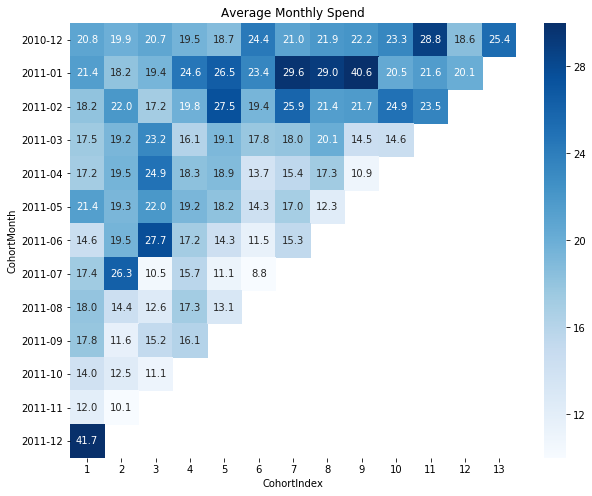

In [20]:
plt.figure(figsize=(10, 8))
plt.title('Average Monthly Spend')
sns.heatmap(cohort_totalsum, annot=True, fmt='.1f', vmin=10, vmax = 30, cmap='Blues')
plt.show()

# 2. Building size-based cohorts

In this section we are going to build cohorts based on size of their transactions on the first month, and convert them into quirtiles and other percentiles that will define their cohorts.

We will calculate these size-based cohorts:

    2.1. TotalSum quartiles
 
    2.2. TotalSum deciles

### 2.1. TotalSum quartiles

We need to extract first offset month (`CohortIndex == 1`) of the customer, and group them into quartiles based on `TotalSum` value

In [21]:
online_first_totalsum = online[online['CohortIndex'] == 1].groupby(['CustomerID'])['TotalSum'].agg('sum')
online_first_totalsum.head(10)

CustomerID
12747     61.97
12748    955.07
12749    144.00
12820     35.40
12822    146.15
12823    306.00
12824    106.38
12826     18.60
12827     14.85
12828    102.30
Name: TotalSum, dtype: float64

In [22]:
quartiles = online_first_totalsum.quantile(q=[.25, .5, .75])
quartiles = quartiles.to_dict()
quartiles

{0.25: 32.160000000000004, 0.5: 62.900000000000006, 0.75: 111.30000000000001}

In [23]:
online_first_totalsum = online_first_totalsum.reset_index()

In [24]:
online_first_totalsum[:5]

,CustomerID,TotalSum
0,12747,61.97
1,12748,955.07
2,12749,144.00
3,12820,35.40
4,12822,146.15


In [25]:
def assign_quartile(value, quartiles=quartiles):
    if value <= quartiles[.25]:
        return 4
    elif value <= quartiles[.5]:
        return 3
    elif value <= quartiles[.75]:
        return 2
    else:
        return 1
        
online_first_totalsum['TotalSum_quartile'] = online_first_totalsum['TotalSum'].map(assign_quartile)

In [26]:
online = online.merge(online_first_totalsum[['CustomerID', 'TotalSum_quartile']],\
                      on='CustomerID', how='left')

### Create cohorts dataset with raw metrics

In [27]:
grouping = online.groupby(['TotalSum_quartile', 'CohortIndex'])

cohort_data = grouping.agg({'CustomerID': pd.Series.nunique,
                           'UnitPrice': np.mean,
                           'Quantity': np.mean,
                           'TotalSum': np.mean})

cohort_data.rename(columns = {'CustomerID': 'CustomerCount',
                           'UnitPrice': 'AveragePrice',
                           'Quantity': 'AverageQuantity',
                           'TotalSum': 'AverageTotalSum'}, inplace = True)

In [28]:
cohort_data[:10]

CustomerCount  AveragePrice  AverageQuantity  \
TotalSum_quartile CohortIndex                                                 
1                 1                      924      3.339704        16.067485   
                  2                      248      3.161287        15.484542   
                  3                      273      3.090443        15.334375   
                  4                      236      2.899989        16.946163   
                  5                      241      2.743152        19.325346   
                  6                      229      7.876118        15.828676   
                  7                      226      2.745967        14.799192   
                  8                      203      2.969116        17.482616   
                  9                      198      2.790862        19.992912   
                  10                     170      2.752251        17.033193   

                               AverageTotalSum  
TotalSum_quartile CohortIndex                   
1                 1                  28.152328  
                  2                  23.891040  
                  3                  26.711495  
                  4                  27.950481  
                  5                  27.265543  
                  6                  33.039593  
                  7                  29.176624  
                  8                  31.477054  
                  9                  37.034903  
                  10                 31.891014

In [29]:
cohort_counts = cohort_data.reset_index().pivot(index='TotalSum_quartile', columns='CohortIndex', values='CustomerCount')
cohort_sizes = cohort_counts[1].values
retention = cohort_counts.divide(cohort_sizes, axis=0)

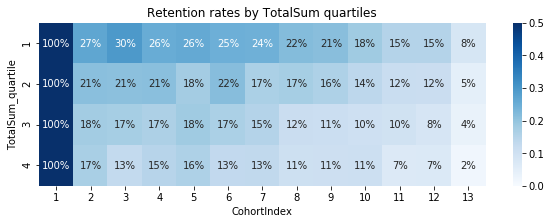

In [30]:
import seaborn as sns

plt.figure(figsize=(10, 3))
plt.title('Retention rates by TotalSum quartiles')
sns.heatmap(retention, annot=True, fmt='.0%', vmin=0.0, vmax=0.5, cmap='Blues')
plt.show()

### 2.2. TotalSum deciles

We need to extract first offset month (`CohortIndex == 1`) of the customer, and group them into deciles based on `TotalSum` value

In [31]:
q = [np.round(i*.1+.1, 1) for i in range(9)]
deciles = online_first_totalsum['TotalSum'].quantile(q=q)
deciles = deciles.to_dict()
deciles

{0.1: 16.5,
 0.2: 27.6,
 0.3: 37.5,
 0.4: 49.65,
 0.5: 62.900000000000006,
 0.6: 77.91000000000001,
 0.7: 99.58000000000001,
 0.8: 132.9,
 0.9: 203.52}

In [32]:
def assign_decile(value, deciles=deciles):
    if value <= deciles[.1]:
        return 10
    elif value <= deciles[.2]:
        return 9
    elif value <= deciles[.3]:
        return 8
    elif value <= deciles[.4]:
        return 7
    elif value <= deciles[.5]:
        return 6
    elif value <= deciles[.6]:
        return 5
    elif value <= deciles[.7]:
        return 4
    elif value <= deciles[.8]:
        return 3
    elif value <= deciles[.9]:
        return 2
    else:
        return 1
        
online_first_totalsum['TotalSum_decile'] = online_first_totalsum['TotalSum'].map(assign_decile)

In [33]:
online = online.merge(online_first_totalsum[['CustomerID', 'TotalSum_decile']],\
                      on='CustomerID', how='left')

In [34]:
grouping = online.groupby(['TotalSum_decile', 'CohortIndex'])

cohort_data = grouping.agg({'CustomerID': pd.Series.nunique,
                           'UnitPrice': np.mean,
                           'Quantity': np.mean,
                           'TotalSum': np.mean})

cohort_data.rename(columns = {'CustomerID': 'CustomerCount',
                           'UnitPrice': 'AveragePrice',
                           'Quantity': 'AverageQuantity',
                           'TotalSum': 'AverageTotalSum'}, inplace = True)

In [35]:
cohort_data.reset_index(level=['TotalSum_decile', 'CohortIndex'], inplace=True)
cohort_counts = cohort_data.pivot(index='TotalSum_decile', columns='CohortIndex', values='CustomerCount')
cohort_sizes = cohort_counts[1].values
retention = cohort_counts.divide(cohort_sizes, axis=0)

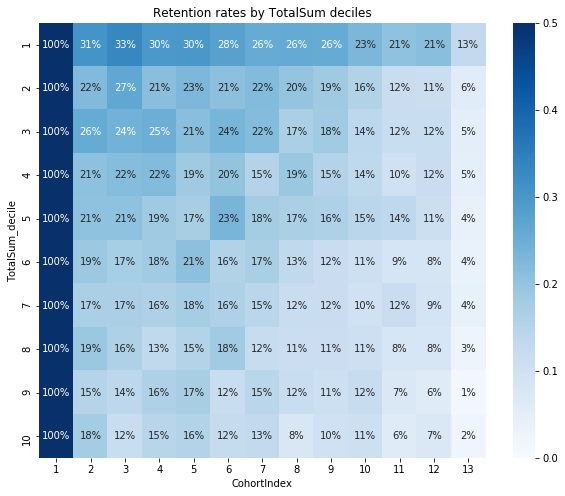

In [36]:
plt.figure(figsize=(10, 8))
plt.title('Retention rates by TotalSum deciles')
sns.heatmap(retention, annot=True, fmt='.0%', vmin=0.0, vmax=0.5, cmap='Blues')
plt.show()

# DATACAMP EXERCISE - Capstone 1

Cohort analysis capstone - Building size based cohort on `Quantity` quartiles in the first month and calculating `TotalSum` metric

In [100]:
data = online[['InvoiceNo', 'Quantity', 'CustomerID', 'TotalSum', 'CohortMonth', 'CohortIndex']]
writer = pd.ExcelWriter('Capstone_1_Data.xlsx')
data.to_excel(writer,'Sheet1')
writer.save()

## FULL CODE IN 1 PLACE

ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


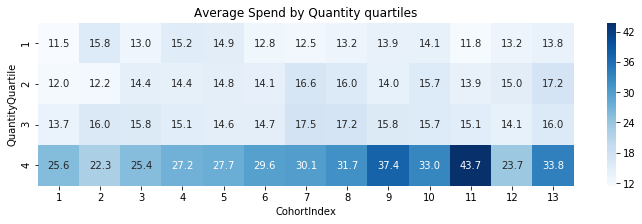

In [102]:
# This will be loaded separately into the datacamp exercise
data = online[['InvoiceNo', 'Quantity', 'CustomerID', 'TotalSum', 'CohortMonth', 'CohortIndex']]

# Calculate total Quantity purchased for each customer in their first month
q_data = data[data['CohortIndex'] == 1].groupby(['CustomerID'])['Quantity'].agg('sum').reset_index()
# Create a new column that calculates quartiles based on first month's Quantity
q_data = q_data.assign(QuantityQuartile = pd.qcut(x=q_data['Quantity'], q=4, labels = range(1,5) ))
# Append the quartile values back to the original dataset
data = data.merge(q_data[['CustomerID', 'QuantityQuartile']], on='CustomerID', how='left').reset_index()
# Calculate average spend for each cohort monthly
q_agg = data.groupby(['QuantityQuartile', 'CohortIndex'])['TotalSum'].mean()
# Pivot the aggregated dataset so that Quartile values are in rows, and Cohort index is in columns 
q_cohorts = q_agg.reset_index().pivot(index='QuantityQuartile', columns='CohortIndex', values='TotalSum')
# Plot the heatmap 
plt.figure(figsize=(12, 3)); plt.title('Average Spend by Quantity quartiles')
sns.heatmap(q_cohorts, annot=True, fmt='.1f', cmap='Blues')
plt.show()